In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.initializers import GlorotUniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from keras.utils import to_categorical
from os import mkdir
from os.path import join, exists
from scipy import signal
import os

### There are two approaches possible for this assignment according to the given data. 
- We can use the given 561 features extracted from signals as training data and train a classifier using various ML algorithms such as SVM, Random Forrest, Logistic Regression, etc.
- We can also use the signals provided directly to train a time-series based model like RNNs, LSTM, etc.

### In this notebook, I will be implementing a LSTM model which corresponds to the second proposed solution. The signals will be directly used as input to train the LSTM. The reason for selection of this approach are as follows;
- Time-series models such as RNNs and LSTMs are specifically designed to capture temporal dependencies in the data. 
-  Training models on raw signals reduces the need for extensive feature engineering.
- Using raw signals allows for end-to-end learning, which I think will be potentially useful for the desired application which is to build a employee security system using gait analysis.

### It is already mentioned in the description of dataset that the data doesn't really have null/missing values so basic data cleaning has already been done. The important factor that needs to be verified is that the data is not very biased, i.e., sufficient data is available for all classes.

In [3]:
with open('/kaggle/input/har-uci/UCI HAR Dataset/UCI HAR Dataset/features.txt') as f:
    features = [line.split()[1] for line in f.readlines()]
    
c=Counter(features)
for key in c.keys():
    if c[key]>1:
        print(key,c[key])

fBodyAcc-bandsEnergy()-1,8 3

fBodyAcc-bandsEnergy()-9,16 3

fBodyAcc-bandsEnergy()-17,24 3

fBodyAcc-bandsEnergy()-25,32 3

fBodyAcc-bandsEnergy()-33,40 3

fBodyAcc-bandsEnergy()-41,48 3

fBodyAcc-bandsEnergy()-49,56 3

fBodyAcc-bandsEnergy()-57,64 3

fBodyAcc-bandsEnergy()-1,16 3

fBodyAcc-bandsEnergy()-17,32 3

fBodyAcc-bandsEnergy()-33,48 3

fBodyAcc-bandsEnergy()-49,64 3

fBodyAcc-bandsEnergy()-1,24 3

fBodyAcc-bandsEnergy()-25,48 3

fBodyAccJerk-bandsEnergy()-1,8 3

fBodyAccJerk-bandsEnergy()-9,16 3

fBodyAccJerk-bandsEnergy()-17,24 3

fBodyAccJerk-bandsEnergy()-25,32 3

fBodyAccJerk-bandsEnergy()-33,40 3

fBodyAccJerk-bandsEnergy()-41,48 3

fBodyAccJerk-bandsEnergy()-49,56 3

fBodyAccJerk-bandsEnergy()-57,64 3

fBodyAccJerk-bandsEnergy()-1,16 3

fBodyAccJerk-bandsEnergy()-17,32 3

fBodyAccJerk-bandsEnergy()-33,48 3

fBodyAccJerk-bandsEnergy()-49,64 3

fBodyAccJerk-bandsEnergy()-1,24 3

fBodyAccJerk-bandsEnergy()-25,48 3

fBodyGyro-bandsEnergy()-1,8 3

fBodyGyro-bandsEnergy()-9,1

### While trying to plot, an error popped up mentioning that some feature names are repeated. When checked I realised that for some features they forgot to add the -X, -Y, -Z at the end and hence as you can see above that these features are repeated exactly thrice, so we need to correct these names manually.

In [4]:
features_set=set()
unique_features=[]
for i,v in enumerate(features):
    if v not in features_set:
        features_set.add(v)
        unique_features.append(v+'-X')
    elif v+'-Y' not in features_set:
        features_set.add(v+'-Y')
        unique_features.append(v+'-Y')
    else:
        features_set.add(v+'-Z')
        unique_features.append(v+'-Z')

print(len(unique_features))

561


In [5]:
X_train=pd.read_csv('/kaggle/input/har-uci/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None, names=unique_features)
subject=pd.read_csv('/kaggle/input/har-uci/UCI HAR Dataset/UCI HAR Dataset/train/subject_train.txt',header=None)
y_train=pd.read_csv('/kaggle/input/har-uci/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt',header=None)
with open('/kaggle/input/har-uci/UCI HAR Dataset/UCI HAR Dataset/activity_labels.txt') as f:
    y_labels = {line.split()[0]: line.split()[1] for line in f.readlines()}
    
print(X_train.shape,y_train.shape,subject.shape)
print(y_labels)

/tmp/ipykernel_27/2526276666.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

  X_train=pd.read_csv('/kaggle/input/har-uci/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None, names=unique_features)


(7352, 561) (7352, 1) (7352, 1)

{'1': 'WALKING', '2': 'WALKING_UPSTAIRS', '3': 'WALKING_DOWNSTAIRS', '4': 'SITTING', '5': 'STANDING', '6': 'LAYING'}


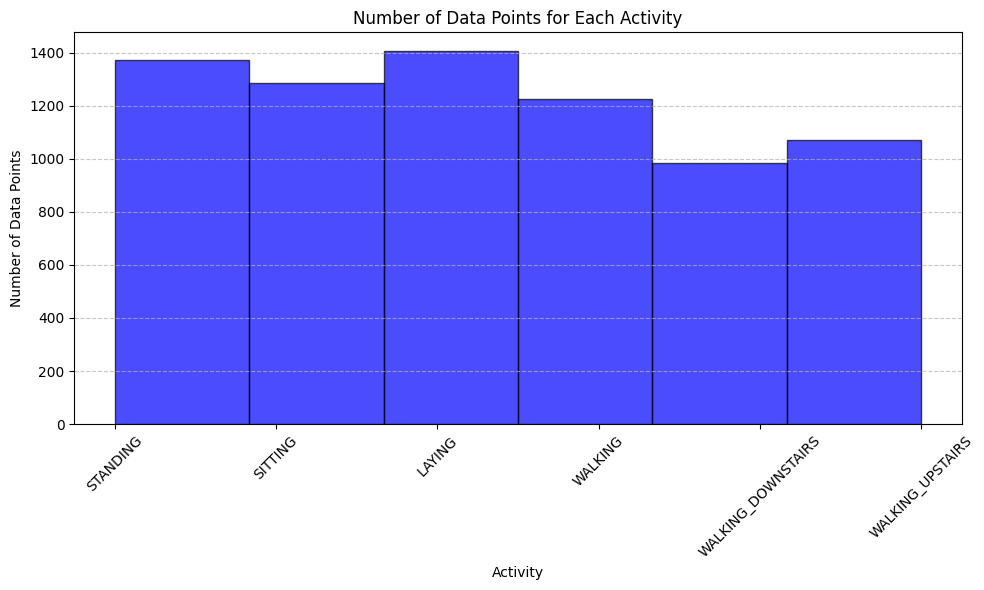

In [6]:
# Plotting number of data points for each y_label
plt.figure(figsize=(10, 6))
y_train_labels = [y_labels[str(label)][:] for label in y_train.values.flatten()]
plt.hist(y_train_labels, bins=len(set(y_train_labels)), alpha=0.7, color='blue', edgecolor='black')
plt.title('Number of Data Points for Each Activity')
plt.xlabel('Activity')
plt.ylabel('Number of Data Points')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

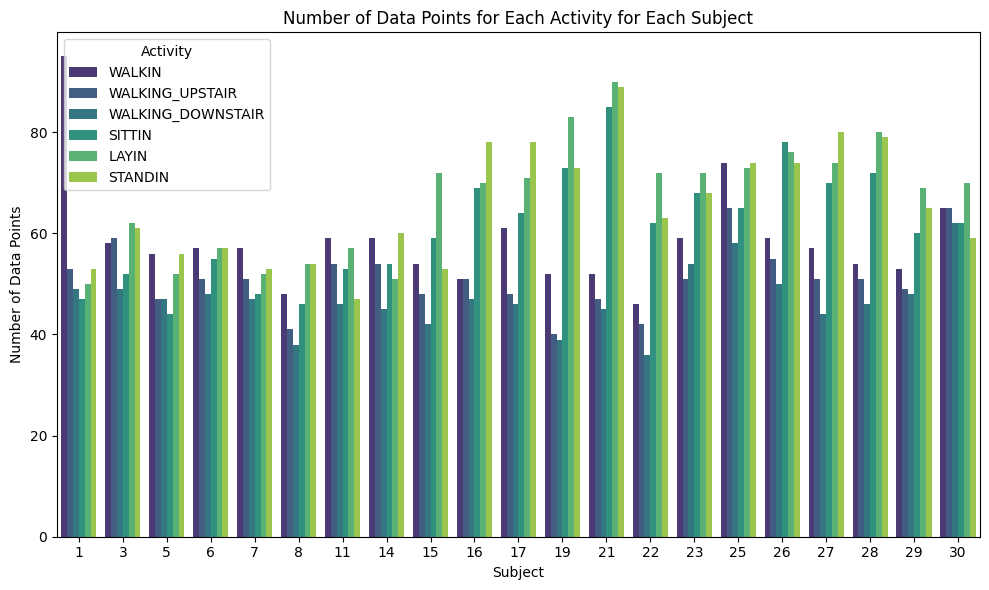

In [7]:
import seaborn as sns

subject_activity_counts = {}
for subject_id in set(subject.values.flatten()):
    subject_data = y_train[subject.values.flatten() == subject_id]
    subject_labels = [y_labels[str(label)][:-1] for label in subject_data.values.flatten()]
    counts = {label: subject_labels.count(label) for label in set(subject_labels)}
    subject_activity_counts[subject_id] = counts

# Convert subject_activity_counts to a DataFrame
subject_activity_df = pd.DataFrame(subject_activity_counts).T.fillna(0)

# Reset the index to use 'Subject' as a column
subject_activity_df.reset_index(inplace=True)
subject_activity_df.rename(columns={'index': 'Subject'}, inplace=True)

# Melt the DataFrame to plot with Seaborn
melted_df = pd.melt(subject_activity_df, id_vars=['Subject'], var_name='Activity', value_name='Number of Data Points')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_df, x='Subject', y='Number of Data Points', hue='Activity', palette='viridis')
plt.xlabel('Subject')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points for Each Activity for Each Subject')
plt.tight_layout()
plt.show()

### Now that we have confirmed that the data is quite well balanced, we can proceed with the training of our model

### Although variable X_train has already been created, it was just to plot and see the data is imbalanced or not. Since it has already been confirmed and I want to train LSTM model, the data required is the signals which have been placed in 'Inertial Signals' folder.

In [8]:
data_dir='/kaggle/input/har-uci/UCI HAR Dataset/UCI HAR Dataset'

signals=[
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

### We need to combine the data, then shuffle and split it, since we are interested in predicting the identity of the person but in the given dataset, in train folder, there is not even a single entry corresponding to 9 people who are entirely in the test folder. This dataset was made in this way since it was originally designed to predict human activity and not person identity.

### One thing we need to make sure is that since labels are from 1 to 30, they are categorical and not numerical , so we want to do one hot encoding while loading y

In [9]:
def load_data(folder): #function to load data
    # Load y
    y_data = pd.read_csv(f'{data_dir}/{folder}/subject_{folder}.txt', header=None)

    # Load X
    X_data = []
    for signal in signals:
        file = f'{data_dir}/{folder}/Inertial Signals/{signal}_{folder}.txt'
        x = pd.read_csv(file, header=None, sep='\s+').to_numpy()
        X_data.append(x)
    X_data = np.transpose(X_data, (1,2,0)) 
    # Since data is usually shapes as (number of samples, timesteps, features) so we need to resize
    
    print("X shape:", X_data.shape)
    print("y shape:", y_data.shape)

    return X_data, y_data

In [10]:
X_train, y_train = load_data('train')
X_test, y_test = load_data('test')

X shape: (7352, 128, 9)

y shape: (7352, 1)

X shape: (2947, 128, 9)

y shape: (2947, 1)


In [11]:
# Concatenating the data
X_= np.concatenate((X_train, X_test), axis=0)
print("Shape of concatenated X_:", X_.shape)
y_= np.concatenate((y_train, y_test), axis=0)
print("Shape of concatenated y_:", y_.shape)

Shape of concatenated X_: (10299, 128, 9)

Shape of concatenated y_: (10299, 1)


In [12]:
# Shuffling the data 
shuffled_indices = np.random.permutation(len(y_))
X_data_shuffled = X_[shuffled_indices]
y_data_shuffled = y_[shuffled_indices]

In [13]:
# before one hot encoding we need to change it so that it starts from 0 instead of 1 
# because to_categorical function expects 0 indexed labels
y_data_shuffled = [z-1 for z in y_data_shuffled]

# One hot encoding the labels
y_data_one_hot = to_categorical(y_data_shuffled)
print("Shape of one-hot encoded y_data:", y_data_one_hot.shape)

Shape of one-hot encoded y_data: (10299, 30)


In [14]:
# Splitting into test and train

X_train, X_test, y_train, y_test = train_test_split(X_data_shuffled, y_data_one_hot, test_size=0.15, random_state=42)

# Check the shapes of the split arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8754, 128, 9)

X_test shape: (1545, 128, 9)

y_train shape: (8754, 30)

y_test shape: (1545, 30)


In [15]:
(y_train) # to make sure its one hot encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

### Our data is ready, lets initialize some parameters and define our LSTM model

In [16]:
num_classes = 30
num_epoch= 100
batch= 32
lr=0.005

## Using initializer and learning rate scheduler for better performance of model. LR scheduler will decrease the learning rate to 0.7 times of its value after every 10 epochs to help the model converge.

In [17]:
initializer = GlorotUniform()

def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.7 
    else:
        return lr 

### The number of hidden units in LSTM model is decided based on experimentation. Smaller numbers like 32 and 64 were tried first but the resultant model wasn't complex enough to capture the relationships in the data and hence resulted in lower accuracies.

In [18]:
model = Sequential([
    LSTM(128, input_shape=(128, 9), kernel_initializer=initializer), 
    Dense(num_classes, activation='softmax', kernel_initializer=initializer)   
])

optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

  super().__init__(**kwargs)


In [19]:
history = model.fit(X_train, y_train, epochs=num_epoch, batch_size=batch, validation_data=(X_test, y_test), callbacks=[lr_scheduler_callback])

Epoch 1/100

274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.0603 - loss: 3.3349 - val_accuracy: 0.0997 - val_loss: 3.1087 - learning_rate: 0.0050

Epoch 2/100

274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0936 - loss: 3.1426 - val_accuracy: 0.1184 - val_loss: 3.0318 - learning_rate: 0.0050

Epoch 3/100

274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1398 - loss: 2.9666 - val_accuracy: 0.1184 - val_loss: 3.1247 - learning_rate: 0.0050

Epoch 4/100

274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0997 - loss: 3.1396 - val_accuracy: 0.0628 - val_loss: 3.3408 - learning_rate: 0.0050

Epoch 5/100

274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0661 - loss: 3.3030 - val_accuracy: 0.0971 - val_loss: 3.1625 - learning_rate: 0.0050

Epoch 6/100

274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1020 - loss: 3.1396 - val_accuracy: 0.1366 - val_loss: 3.0503 - learning_rate: 0.0050

Epoch 7/100

274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1

In [20]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8751 - loss: 0.4531

Test Loss: 0.5136666297912598, Test Accuracy: 0.8601941466331482


In [21]:
model.save("LSTM_model.h5")

In [22]:
model = load_model("/kaggle/input/lstm-model-gait/LSTM_model.h5")

In [23]:
loss, accuracy = model.evaluate(X_train, y_train)
print(f'Training Loss: {loss}, Training Accuracy: {accuracy}')

274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9437 - loss: 0.1913

Training Loss: 0.19721731543540955, Training Accuracy: 0.9435686469078064


In [24]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9541 - loss: 0.1478

Test Loss: 0.1602020412683487, Test Accuracy: 0.9488673210144043


### After training, our model has attained 94% training as well as testing accuracy. Clearly the model is not overfitting and is working as desired. Let's try some other metrics.

In [25]:
y_true = y_test 
y_true = np.argmax(y_true, axis=1)
y_pred_probs = model.predict(X_test) 
y_pred = np.argmax(y_pred_probs, axis=1)

# precision
precision = precision_score(y_true, y_pred, average='weighted')
print("Precision:", precision)

# recall
recall = recall_score(y_true, y_pred, average='weighted')
print("Recall:", recall)

# F1-score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1-score:", f1)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Precision: 0.9504852352915963

Recall: 0.9488673139158577

F1-score: 0.9488017282470889


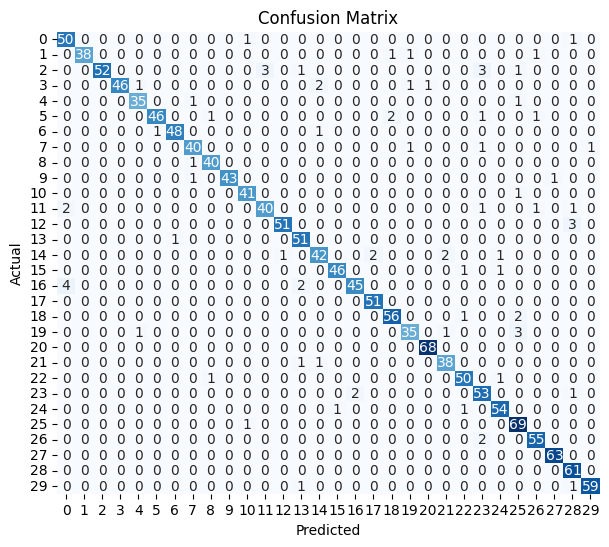

In [26]:
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### No abnormalities in the metrics as well as in the confusion matrix.

### This completes the development of the LSTM model for GAIT Analysis

## Now for testing on real data, I have collected 5 of my friends data
- First comes pre-processing them into the form which lstm model accepts
- Then retraining the model with this data
- Training another model for predicting the activity
- Testing out various confidence scores to set the threshold
- Set a threshold of apt confidence score on both identity detection and activity detection to detect if any unknown person enters the premises.

## Pre-processing raw signal data. In the original UCI HAR dataset : 
- Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz.
- The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used.

## Function for butterworth lowpass filter with cutoff frequency of 0.3 Hz to extract body acceleration from total acceleration as done with the original UCI HAR dataset

In [36]:
def butter_lowpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [37]:
save_dir = '/kaggle/working/preprocessed'
if not exists(save_dir):
    mkdir(save_dir)

- Subtracting start time to start from zero
- Cutting down on frequency to approx 60 Hz, i.e., 60 readings per second
- Appyling butterworth low pass filter
- Trimming the first and last 3 seconds

In [38]:
def process_csv(input_csv, output_csv):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(input_csv, usecols=range(7))
    
    # Calculate the time difference from the first timestamp
    first_timestamp = df['time'].iloc[1] 
    df['time'] = df['time'] - first_timestamp
    
    # Truncate timestamps to 2 decimal places
    df['time'] = df['time'].apply(lambda x: int(x * 100) / 100)
    
    # Keep only the first row for each unique timestamp
    df = df.drop_duplicates(subset=['time'], keep='first')
    
    # Apply Butterworth low-pass filter to accelerometer data to extract body acceleration
    cutoff_freq = 0.3  # 0.3 Hz cutoff frequency
    nyq_freq = 30  # Nyquist frequency (sample rate/2)
    order = 4  # Filter order
    for col in ['ax', 'ay', 'az']:
        df[f'body{col}'] = butter_lowpass_filter(df[col].values, cutoff_freq, nyq_freq, order=order)
    
    # Trim data corresponding to first and last 3 seconds
    start_time = df['time'].iloc[0]
    end_time = df['time'].iloc[-1]
    df = df[(df['time'] >= start_time + 3) & (df['time'] <= end_time - 3)]
    
    # Save the processed DataFrame to a new CSV file
    df.to_csv(output_csv, index=False)
    
    print("Processed data saved to:", output_csv)


## Applying above function to all csvs

In [39]:
def process_csvs_in_directory(input_dir):

    subdirectories = [subdir for subdir in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, subdir))]

    # Process CSV files in each subdirectory
    for subdir in subdirectories:
        subdirectory_path = os.path.join(input_dir, subdir)
        output_dir = os.path.join('/kaggle/working/preprocessed', subdir)

         # Create output directory if it doesn't exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Process each CSV file in the subdirectory
        for file in os.listdir(subdirectory_path):
            if file.endswith('.csv'):
                input_csv = os.path.join(subdirectory_path, file)
                output_filename = f'{os.path.splitext(file)[0]}_processed.csv'
                output_csv = os.path.join(output_dir, output_filename)
                process_csv(input_csv, output_csv)


In [40]:
input_dir = '/kaggle/input/real-data-acc-gyro/real_data_acc_gyro' 
process_csvs_in_directory(input_dir)

Processed data saved to: /kaggle/working/preprocessed/Sourabh/upstairs_processed.csv
Processed data saved to: /kaggle/working/preprocessed/Sourabh/walking_processed.csv
Processed data saved to: /kaggle/working/preprocessed/Sourabh/downstairs_processed.csv
Processed data saved to: /kaggle/working/preprocessed/Sourabh/standing_processed.csv
Processed data saved to: /kaggle/working/preprocessed/Sourabh/laying_processed.csv
Processed data saved to: /kaggle/working/preprocessed/Sourabh/sitting_processed.csv
Processed data saved to: /kaggle/working/preprocessed/Satyam/upstairs_processed.csv
Processed data saved to: /kaggle/working/preprocessed/Satyam/walking_processed.csv
Processed data saved to: /kaggle/working/preprocessed/Satyam/downstairs_processed.csv
Processed data saved to: /kaggle/working/preprocessed/Satyam/standing_processed.csv
Processed data saved to: /kaggle/working/preprocessed/Satyam/laying_processed.csv
Processed data saved to: /kaggle/working/preprocessed/Satyam/sitting_proc

## Following is the code to clear the kaggle working directory, I saved the preprocessed files and uploaded them as a new dataset

In [6]:
import shutil
import os

def clear_working_directory():
    # Get the path to the working directory
    working_dir = '/kaggle/working'

    # Iterate over all files and folders in the working directory
    for item in os.listdir(working_dir):
        item_path = os.path.join(working_dir, item)
        # Check if item is a file, then delete it
        if os.path.isfile(item_path):
            os.unlink(item_path)
        # Check if item is a directory, then delete it recursively
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)

# Call the function to clear the working directory
clear_working_directory()

print("Working directory cleared successfully.")


Working directory cleared successfully.


## Now I need to pre-process to form time series data. I'll be doing in a similar manner as done originally with 50% overlap and 128 signals in each row.
## It creates 9 feature files and 1 activity label file per person.

In [40]:
def extract_features(input_dir):
    # Iterate over each subdirectory (each person)
    for person_dir in os.listdir(input_dir):
        person_path = os.path.join(input_dir, person_dir)
        if os.path.isdir(person_path):
            # Initialize lists to store features for each column
            features = [[] for _ in range(9)]
            activity_labels = []

            # Iterate over each CSV file (each activity)
            for file in sorted(os.listdir(person_path)):
                if file.endswith('.csv'):
                    csv_path = os.path.join(person_path, file)
                    activity_name = file.split('_')[0]  # Extract activity name from file name

                    df = pd.read_csv(csv_path)

                    # Extract features from each column (except the first one)
                    for col_idx, col in enumerate(df.columns[1:]):
                        col_data = df[col].values
                        num_entries = len(col_data)
                        window_size = 128
                        overlap = int(window_size / 2)

                        # Extract features with 50% overlap
                        for i in range(0, num_entries - window_size + 1, overlap):
                            feature_entry = ','.join(map(str, col_data[i:i+window_size]))

                            # Append the feature entry to the corresponding feature file
                            features[col_idx].append(feature_entry)
                            if col_idx==1:
                                activity_labels.append(activity_name)

            # Verify number of entries in features and activity labels
            num_entries_features = len(features[0])  # Using the length of the first feature list
            num_entries_activity_labels = len(activity_labels)
            if num_entries_features != num_entries_activity_labels:
                print(f"WARNING: Number of entries in features ({num_entries_features}) does not match number of entries in activity labels ({num_entries_activity_labels}) for person: {person_dir}")

            # Save features to separate files
            for idx, feature_list in enumerate(features):
                with open(f'/kaggle/working/{person_dir}_feature_{idx+1}.txt', 'a') as f:
                    f.write('\n'.join(feature_list) + '\n')

            # Save activity labels to a file
            with open(f'/kaggle/working/{person_dir}_activity_label.txt', 'a') as f:
                f.write('\n'.join(activity_labels) + '\n')

In [41]:
# Example usage:
input_dir = '/kaggle/input/preprocessed-csvs/preprocessed'  
extract_features(input_dir)

## Function to check whether number of features, columns in each and corresponding activities are consistent or not.

In [44]:
def verify_features(person_name):
    # Initialize dictionaries to store number of entries and column count
    num_entries = {}
    column_counts = {}

    # Read feature files and activity labels file
    for idx in range(1, 10):
        feature_file = f'{person_name}_feature_{idx}.txt'
        with open(feature_file, 'r') as f:
            lines = f.readlines()
            num_entries[idx] = len(lines)
            column_counts[idx] = len(lines[0].strip().split(','))

    # Read activity labels file
    activity_labels_file = f'{person_name}_activity_label.txt'
    with open(activity_labels_file, 'r') as f:
        activity_labels = f.read().strip().split('\n')

    # Verify number of entries and column count
    print(f'Person: {person_name}')
    for idx in range(1, 10):
        print(f'Feature {idx}: {num_entries[idx]} entries, {column_counts[idx]} columns')
    print(f'Activity Labels: {len(activity_labels)} entries')


In [46]:
# Verify features for each person
for person_dir in os.listdir(input_dir):
    if os.path.isdir(os.path.join(input_dir, person_dir)):
        verify_features(person_dir)


Person: Sourabh
Feature 1: 775 entries, 128 columns
Feature 2: 775 entries, 128 columns
Feature 3: 775 entries, 128 columns
Feature 4: 775 entries, 128 columns
Feature 5: 775 entries, 128 columns
Feature 6: 775 entries, 128 columns
Feature 7: 775 entries, 128 columns
Feature 8: 775 entries, 128 columns
Feature 9: 775 entries, 128 columns
Activity Labels: 775 entries
Person: Satyam
Feature 1: 608 entries, 128 columns
Feature 2: 608 entries, 128 columns
Feature 3: 608 entries, 128 columns
Feature 4: 608 entries, 128 columns
Feature 5: 608 entries, 128 columns
Feature 6: 608 entries, 128 columns
Feature 7: 608 entries, 128 columns
Feature 8: 608 entries, 128 columns
Feature 9: 608 entries, 128 columns
Activity Labels: 608 entries
Person: Animesh
Feature 1: 780 entries, 128 columns
Feature 2: 780 entries, 128 columns
Feature 3: 780 entries, 128 columns
Feature 4: 780 entries, 128 columns
Feature 5: 780 entries, 128 columns
Feature 6: 780 entries, 128 columns
Feature 7: 780 entries, 128 col

## Now concatenate them, to create 9 files corresponding features and create another file for person data

In [2]:
def concatenate_features(input_dir):
    # Initialize a dictionary to store concatenated features for each feature index
    all_features = {idx: [] for idx in range(1, 10)}

    # Initialize lists to store concatenated activity labels and person labels
    all_activity_labels = []
    all_person_labels = []

    # Iterate over each feature file
    for file in sorted(os.listdir(input_dir)):
        if not file.endswith('_activity_label.txt'):
            feature_idx = int(file.split('_')[2].split('.')[0])  # Extract feature index from file name
            feature_path = os.path.join(input_dir, file)

            # Read feature file and append features to the corresponding list in all_features dictionary
            with open(feature_path, 'r') as f:
                all_features[feature_idx] += f.readlines()

    # Iterate over each activity labels file
    for file in sorted(os.listdir(input_dir)):
        if file.endswith('_activity_label.txt'):
            person_name = file.split('_')[0]  # Extract person name from file name
            activity_labels_path = os.path.join(input_dir, file)

            # Read activity labels file and append labels to all_activity_labels list
            with open(activity_labels_path, 'r') as f:
                labels = f.readlines()
                num_entries = len(labels)
                all_activity_labels += labels
                all_person_labels += [person_name] * num_entries
                
    # Verify that the lengths of all lists match
    num_entries_features = len(all_features[1])  # Using the length of the first feature list
    num_entries_activity_labels = len(all_activity_labels)
    num_entries_person_labels = len(all_person_labels)
    if num_entries_features != num_entries_activity_labels or num_entries_features != num_entries_person_labels:
        print(f"WARNING: Lengths of concatenated features, activity labels, and person labels do not match.")
    print(num_entries_features, num_entries_activity_labels, num_entries_person_labels)
    # Save concatenated features to separate files
    for idx, feature_list in all_features.items():
        with open(f'/kaggle/working/X_{idx}.txt', 'w') as f:
            f.write('\n'.join(feature_list) + '\n')

    # Save concatenated activity labels to a single file
    with open('/kaggle/working/y_activity.txt', 'w') as f:
        f.write('\n'.join(all_activity_labels) + '\n')

    # Save concatenated person labels to a single file
    with open('/kaggle/working/y_person.txt', 'w') as f:
        f.write('\n'.join(all_person_labels) + '\n')


In [5]:
# Example usage:
input_dir = '/kaggle/input/preprocessed-texts/preprocessed_txts' 
concatenate_features(input_dir)

3661 3661 3661


## Another function to verify if the process was done smoothly

In [7]:
def check_entries_columns(input_dir):
    # Initialize dictionaries to store counts for each features file and both y files
    features_counts = {idx: {'entries': 0, 'columns': 0} for idx in range(1, 10)}
    y_activity_counts = {'entries': 0, 'columns': 0}
    y_person_counts = {'entries': 0, 'columns': 0}

    # Iterate over each features file
    for idx in range(1, 10):
        feature_file = f'X_{idx}.txt'
        feature_path = os.path.join(input_dir, feature_file)

        # Read the features file
        with open(feature_path, 'r') as f:
            lines = f.readlines()
            features_counts[idx]['entries'] = len(lines)
            if lines:  # Check if the file is not empty
                features_counts[idx]['columns'] = len(lines[0].strip().split(','))

    # Read the y_activity file
    y_activity_path = os.path.join(input_dir, 'y_activity.txt')
    with open(y_activity_path, 'r') as f:
        lines = f.readlines()
        y_activity_counts['entries'] = len(lines)
        if lines:  # Check if the file is not empty
            y_activity_counts['columns'] = len(lines[0].strip().split(','))

    # Read the y_person file
    y_person_path = os.path.join(input_dir, 'y_person.txt')
    with open(y_person_path, 'r') as f:
        lines = f.readlines()
        y_person_counts['entries'] = len(lines)
        if lines:  # Check if the file is not empty
            y_person_counts['columns'] = len(lines[0].strip().split(','))

    return features_counts, y_activity_counts, y_person_counts


In [8]:
input_dir = '/kaggle/input/acc-and-gyro-preprocessed/fully_preprocessed_data' 
features_counts, y_activity_counts, y_person_counts = check_entries_columns(input_dir)
print("Features Counts:")
for idx, counts in features_counts.items():
    print(f"Features {idx}: Entries={counts['entries']}, Columns={counts['columns']}")

print("\nY Activity Counts:")
print(f"Entries={y_activity_counts['entries']}, Columns={y_activity_counts['columns']}")

print("\nY Person Counts:")
print(f"Entries={y_person_counts['entries']}, Columns={y_person_counts['columns']}")


Features Counts:
Features 1: Entries=7322, Columns=128
Features 2: Entries=7322, Columns=128
Features 3: Entries=7322, Columns=128
Features 4: Entries=7322, Columns=128
Features 5: Entries=7322, Columns=128
Features 6: Entries=7322, Columns=128
Features 7: Entries=7322, Columns=128
Features 8: Entries=7322, Columns=128
Features 9: Entries=7322, Columns=128

Y Activity Counts:
Entries=7322, Columns=1

Y Person Counts:
Entries=3661, Columns=1


## Now our data is ready, we can continue with re-training 2 models, one for activity prediction and another for person/identity prediction

## Function to read X data

In [3]:
def read_data(file_prefix='/kaggle/input/acc-and-gyro-preprocessed/fully_preprocessed_data/X', num_files=9):
    all_data = []
    for i in range(1, num_files + 1):
        file_path = f"{file_prefix}_{i}.txt"
        with open(file_path, 'r') as file:
            lines = file.read().splitlines()
            non_empty_lines = [line for line in lines if line.strip()]
            # Convert each line into a numpy array
            data = np.array([list(map(float, line.split(','))) for line in non_empty_lines])
            all_data.append(data)
    return np.array(all_data)


data = read_data()
X = np.transpose(data,(1,2,0))
print(X.shape)

(3661, 128, 9)


## Function to read y data and one hot encode it

In [4]:
def read_labels(file_path):
    label_dict = {}
    
    with open(file_path, 'r') as file:
        lines = file.read().splitlines()
        non_empty_lines = [line for line in lines if line.strip()]
        
        # Create a dictionary to map labels to numerical values
        unique_labels = set(non_empty_lines)
        for i, label in enumerate(unique_labels):
            label_dict[label] = i
        
        # Convert labels to numerical values
        numerical_labels = [label_dict[label] for label in non_empty_lines]
        
        # One-hot encode the labels using to_categorical
        encoded_labels = to_categorical(numerical_labels, num_classes=len(unique_labels))
    
    return encoded_labels, label_dict

y_1, activity_dict = read_labels('/kaggle/input/acc-and-gyro-preprocessed/fully_preprocessed_data/y_activity.txt')
print(y_1.shape, activity_dict)
y_2, person_dict = read_labels('/kaggle/input/acc-and-gyro-preprocessed/fully_preprocessed_data/y_person.txt')
print(y_2.shape, person_dict)

(3661, 6) {'sitting': 0, 'downstairs': 1, 'upstairs': 2, 'walking': 3, 'standing': 4, 'laying': 5}
(3661, 6) {'Sourabh': 0, 'Viraj': 1, 'Satyam': 2, 'Animesh': 3, 'Anushka': 4, 'Naman': 5}


In [5]:
print(y_1)

[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [6]:
print(y_2)

[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


## Shuffling the data

In [7]:
perm = np.random.permutation(len(X))
X_shuffled = X[perm]
y1_shuffled = y_1[perm]
y2_shuffled = y_2[perm]

print(X_shuffled.shape)
print(y1_shuffled.shape)
print(y2_shuffled.shape)

(3661, 128, 9)
(3661, 6)
(3661, 6)


## Splitting for both models

In [8]:
# Splitting into test and train

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_shuffled, y1_shuffled, test_size=0.15, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_shuffled, y2_shuffled, test_size=0.15, random_state=42)

# Check the shapes of the split arrays
print("X_train shape:", X_train1.shape)
print("X_test shape:", X_test1.shape)
print("y_train shape:", y_train1.shape)
print("y_test shape:", y_test1.shape)

print("X_train shape:", X_train2.shape)
print("X_test shape:", X_test2.shape)
print("y_train shape:", y_train2.shape)
print("y_test shape:", y_test2.shape)

X_train shape: (3111, 128, 9)
X_test shape: (550, 128, 9)
y_train shape: (3111, 6)
y_test shape: (550, 6)
X_train shape: (3111, 128, 9)
X_test shape: (550, 128, 9)
y_train shape: (3111, 6)
y_test shape: (550, 6)


## Parameters for both models

In [16]:
num_classes = 6
num_epoch= 100
batch= 32
lr=0.006
lr2=0.007

initializer = GlorotUniform()

def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.7 
    else:
        return lr 

optimizer = Adam(learning_rate=lr)
optimizer2 = Adam(learning_rate=lr2)

## Training for first model

In [10]:
model1 = Sequential([
    LSTM(128, input_shape=(128, 9), kernel_initializer=initializer), 
    Dense(num_classes, activation='softmax', kernel_initializer=initializer)   
])

model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
history1 = model1.fit(X_train1, y_train1, epochs=num_epoch, batch_size=batch, validation_data=(X_test1, y_test1), callbacks=[lr_scheduler_callback])

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4127 - loss: 1.2571 - val_accuracy: 0.4982 - val_loss: 0.9597 - learning_rate: 0.0060
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4989 - loss: 1.0391 - val_accuracy: 0.5782 - val_loss: 0.9675 - learning_rate: 0.0060
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5396 - loss: 0.9387 - val_accuracy: 0.4436 - val_loss: 1.4825 - learning_rate: 0.0060
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5336 - loss: 1.0281 - val_accuracy: 0.5018 - val_loss: 1.0292 - learning_rate: 0.0060
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5505 - loss: 0.9183 - val_accuracy: 0.5764 - val_loss: 0.8337 - learning_rate: 0.0060
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5550 - loss: 0.8959 - val_accuracy: 0.5927 - val_loss: 0.8105 - learning_rate: 0.0060
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6137 - loss: 0.7551 - val_

In [12]:
loss1, accuracy1 = model1.evaluate(X_test1, y_test1)
print(f'Test Loss: {loss1}, Test Accuracy: {accuracy1}')

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8840 - loss: 0.3907
Test Loss: 0.4332854151725769, Test Accuracy: 0.8581818342208862


## 85% accuracy on unseen data and 89% on seen data for activity prediction

## Now lets train second model for identity verification

In [17]:
model2 = Sequential([
    LSTM(128, input_shape=(128, 9), kernel_initializer=initializer), 
    Dense(num_classes, activation='softmax', kernel_initializer=initializer)   
])

model2.compile(optimizer=optimizer2, loss='categorical_crossentropy', metrics=['accuracy'])
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

In [18]:
history2 = model2.fit(X_train2, y_train2, epochs=num_epoch, batch_size=batch, validation_data=(X_test2, y_test2), callbacks=[lr_scheduler_callback])

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3426 - loss: 1.5462 - val_accuracy: 0.3055 - val_loss: 1.5659 - learning_rate: 0.0070
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4095 - loss: 1.4421 - val_accuracy: 0.4291 - val_loss: 1.3798 - learning_rate: 0.0070
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4780 - loss: 1.3181 - val_accuracy: 0.4818 - val_loss: 1.2160 - learning_rate: 0.0070
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5427 - loss: 1.1259 - val_accuracy: 0.6182 - val_loss: 1.1009 - learning_rate: 0.0070
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5724 - loss: 1.0128 - val_accuracy: 0.5545 - val_loss: 0.9942 - learning_rate: 0.0070
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5952 - loss: 0.9015 - val_accuracy: 0.6618 - val_loss: 0.8713 - learning_rate: 0.0070
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6021 - loss: 0.9957 - 

In [19]:
loss2, accuracy2 = model2.evaluate(X_test2, y_test2)
print(f'Test Loss: {loss2}, Test Accuracy: {accuracy2}')

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8623 - loss: 0.4535
Test Loss: 0.47580742835998535, Test Accuracy: 0.8672727346420288


## 86% accuracy on unseen data and 90% on seen data

In [20]:
model1.save('model1.h5')
model2.save('model2.h5')

## Now lets implement the thresholding part for identifying unknown persons/activity

In [29]:
activity_dict = {0:'sitting', 1:'downstairs', 2:'upstairs', 3:'walking', 4:'standing', 5:'laying'}
person_dict = {0:'Sourabh', 1:'Viraj', 2:'Satyam', 3:'Animesh', 4:'Anushka', 5:'Naman'}



In [59]:
model_activity = load_model('/kaggle/input/models-gait-analysis/model1.h5')
model_person = load_model('/kaggle/input/models-gait-analysis/model2.h5')

## Tried 0.6,0.7,0.8 but found best results in 0.5

In [253]:
threshold = 0.5

## Function which takes csv, selects a 128 length window and predicts person as well as activity

In [251]:
def predict_person_activity(csv_file, model_person, model_activity, person_dict, activity_dict, threshold):
    # Read CSV file
    df = pd.read_csv(csv_file)
    
    # Extract random window of 128 samples
    start_index = np.random.randint(0, (len(df) - 128) // 128 ) * 128
    window_data = df.iloc[start_index:start_index+128, 1:].values
    
    print(window_data.shape)
    
    # Reshape to match input shape
    window_data = np.expand_dims(window_data, axis=0)
    
    # Predict using model for person
    person_confidence = model_person.predict(window_data)
    if np.max(person_confidence) > threshold:
        predicted_person_index = np.argmax(person_confidence)
        predicted_person = person_dict[predicted_person_index]
    else:
        predicted_person = "Unknown"
    
    # Predict using model for activity
    activity_confidence = model_activity.predict(window_data)
    if np.max(activity_confidence) > threshold:
        predicted_activity_index = np.argmax(activity_confidence)
        predicted_activity = activity_dict[predicted_activity_index]
    else:
        predicted_activity = "Unknown"
    
    return predicted_person, predicted_activity


## Making predictions for my csv files (its correctly identifying them most of the time)

In [261]:
folder_path = '/kaggle/input/preprocessed-csvs/preprocessed/Animesh'

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        person, activity = predict_person_activity(file_path, model_person, model_activity, person_dict, activity_dict, threshold)
        print('File being used for prediction:', file_path)
        print("Predicted Person:", person)
        print("Predicted Activity:", activity)

(128, 9)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
File being used for prediction: /kaggle/input/preprocessed-csvs/preprocessed/Animesh/downstairs_processed.csv
Predicted Person: Animesh
Predicted Activity: downstairs
(128, 9)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
File being used for prediction: /kaggle/input/preprocessed-csvs/preprocessed/Animesh/standing_processed.csv
Predicted Person: Animesh
Predicted Activity: standing
(128, 9)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
File being used for prediction: /kaggle/input/preprocessed-csvs/preprocessed/Animesh/upstairs_processed.csv
Predicted Person: Animesh
Predicted Activity: upstairs
(128, 9)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
File being used for prediction: /kaggle/input/preprocessed-csvs/preprocessed/Animesh/laying_processed.csv
Predicted Person: Animesh
Predicted Activity: laying
(128, 9)

## Making prediction on data of an unknown person while walking upstairs and downstairs. Models predict unknown for both activities and person as well

In [262]:
folder_path = '/kaggle/input/unknown-acc-gyro'

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        person, activity = predict_person_activity(file_path, model_person, model_activity, person_dict, activity_dict, threshold)
        print('File being used for prediction:', file_path)
        print("Predicted Person:", person)
        print("Predicted Activity:", activity)

(128, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
File being used for prediction: /kaggle/input/unknown-acc-gyro/harsh_downstairs.csv
Predicted Person: Unknown
Predicted Activity: Unknown
(128, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
File being used for prediction: /kaggle/input/unknown-acc-gyro/Harsh_upstairs.csv
Predicted Person: Unknown
Predicted Activity: Unknown
